<a href="https://colab.research.google.com/github/AnusreeMandal/twitter-sentiment-analysis/blob/main/twitter_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#installi pip install kaggle

! pip install kaggle




**Uploading the Kaggle .json file\**


In [3]:
#configuring the path of Kaggle.json file

! mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Importing the Twitter Sentiment Analysis Dataset\

In [4]:
#API to fetch the dataset from kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

100%|██████████| 80.9M/80.9M [00:00<00:00, 150MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#printing the stopwords in english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Data Processing


In [8]:
import pandas as pd

# Assuming the downloaded data is in a CSV file named 'training.1600000.processed.noemoticon.csv'
# Adjust the file name if necessary
file_path = f"{path}/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(file_path, encoding='latin-1', header=None)

In [9]:
# Display the first few rows of the DataFrame
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
# Get information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
# Check for missing values
df.isnull().sum()

,0
0,0
1,0
2,0
3,0
4,0
5,0


In [12]:
#naming the column names and reading the datasets again

column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(file_path, encoding='latin-1', header=None, names=column_names)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [14]:
# checking the distribution of the target column
df['target'].value_counts()

,count
target,
0,800000
4,800000


Convert the label of traget 4 to 1


In [15]:
df.replace({'target': {4: 1}}, inplace=True)  # Replaces 4 with 1 in the 'target' column

0--->negative tweet

1--->positive tweet

**Stemming** [ a process of reducing similar words to its root meaning ]

In [16]:
port_stem = PorterStemmer()

In [17]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content=' '.join(stemmed_content)
    return stemmed_content


In [18]:
df['stemmed content']=df['text'].apply(stemming)

In [19]:
df.head()

,target,ids,date,flag,user,text,stemmed content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [20]:
print(df['stemmed content'])


0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed content, Length: 1600000, dtype: object


In [21]:
print(df['target'])


0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [22]:
# separating the data and label
X = df['stemmed content'].values
Y = df['target'].values

In [23]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [24]:
print(Y)


[0 0 0 ... 1 1 1]


Splitting data into train and test data

In [33]:
X_train, X_test, Y_train, Y_test, Y_train_indices, Y_test_indices = train_test_split(X, Y, range(len(X)), test_size = 0.1, stratify=Y, random_state=2)


In [34]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(1600000,)
(1440000,)
(160000,)


In [35]:
print(Y.shape)
print(Y_train.shape)
print(Y_test.shape)

(1600000,)
(1440000,)
(160000,)


In [36]:
print(X_train)

['feel like work becuz im effin horni'
 'fatman got littl jew fro shave damn'
 'freemissryd come home alreadi life bore without around' ...
 'fenner cool quot add quot okay know quot quot refer account name quot quot still sound funni come'
 'six pack juli ab beer even like beer punish'
 'love wake folger bad voic deeper']


In [37]:
print(X_test)

['alexvonvaupel share deet photo renku project soon interest prob worth explor broad scale'
 'orthodontist appt go boo hoo done brace serious wait killin em smile haha'
 'n quad' ... 'hmmm need review previou word aim write anoth end day'
 'divebunni poor great select wine socal'
 'musiclikemerci glad came watch last five year anoth night board meet monday night']


In [38]:
#converting the textual data to numerical data

vectorizer = TfidfVectorizer()
# Fit and transform on the original text data (X)
X_train = vectorizer.fit_transform(X[Y_train_indices])
X_test = vectorizer.transform(X[Y_test_indices])



In [39]:
print(X_train)

  (0, 140414)	0.23510973174492172
  (0, 253306)	0.20989916743831274
  (0, 480730)	0.20791176343014625
  (0, 39517)	0.5442402674140161
  (0, 191949)	0.23658323758073335
  (0, 124178)	0.5009098608163001
  (0, 182979)	0.5043398323876811
  (1, 139329)	0.5535404239764236
  (1, 163657)	0.1790916056140654
  (1, 256084)	0.2324974076628597
  (1, 211616)	0.4650971855507986
  (1, 150159)	0.43166246378558804
  (1, 391527)	0.37884912323076886
  (1, 96496)	0.24756740179431355
  (2, 149200)	0.6990451071142899
  (2, 84950)	0.228293337690162
  (2, 181827)	0.22667234804878209
  (2, 13488)	0.2746918607123101
  (2, 252766)	0.2691390741081691
  (2, 52422)	0.2744074166366401
  (2, 478718)	0.30928207079919917
  (2, 25322)	0.29831434367036275
  (3, 105553)	0.912675414558782
  (3, 443848)	0.4086851938350052
  (4, 297760)	0.3227325472769045
  :	:
  (1439997, 151750)	0.16772349219006877
  (1439997, 355841)	0.7608099591260032
  (1439997, 414898)	0.12152358340884102
  (1439997, 87003)	0.15005568618538007
  (143999

In [40]:
print(X_test)

  (0, 10986)	0.45215911572223216
  (0, 57292)	0.34923184414720254
  (0, 103849)	0.3697984462037016
  (0, 136027)	0.29348269692148443
  (0, 195530)	0.21918922765221482
  (0, 340148)	0.2146426760569468
  (0, 349704)	0.24634564528631475
  (0, 350126)	0.23543097744137334
  (0, 383145)	0.3203346684648424
  (0, 390959)	0.22842923564835296
  (0, 405860)	0.17677631588426657
  (0, 481168)	0.23330852861538307
  (1, 23344)	0.3365984529499188
  (1, 51593)	0.2473013225678171
  (1, 53782)	0.3372365781457033
  (1, 114644)	0.20813228546942747
  (1, 127433)	0.2673950821601698
  (1, 161559)	0.12878616634004003
  (1, 169850)	0.18198458024036512
  (1, 182386)	0.30464244800101703
  (1, 234424)	0.3614926380681113
  (1, 328292)	0.4032554322189012
  (1, 388260)	0.2527978056479474
  (1, 402402)	0.2544262864362059
  (1, 469696)	0.18042512989832027
  :	:
  (159997, 101165)	0.17364895607184264
  (159997, 129450)	0.2769802129453699
  (159997, 180530)	0.3521220681437496
  (159997, 309208)	0.21462407458127927
  (159

Training the Machine learning model using Logistic Regression

In [46]:
model=LogisticRegression(max_iter=3000)

In [47]:
model.fit(X_train,Y_train)

LogisticRegression(max_iter=3000)

# Model Evaluation

Accuracy Score

In [48]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train,X_train_prediction)

In [49]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.8037861111111111


In [50]:
# accuracy score on the testing data
X_test_prediction = model.predict(X_test)
testing_data_accuracy = accuracy_score(Y_test,X_test_prediction)

In [75]:
from sklearn.metrics import  confusion_matrix
cm = confusion_matrix(Y_test, X_test_prediction)

In [76]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[60762 19238]
 [16139 63861]]


In [79]:
com = confusion_matrix(Y_train, X_train_prediction)
print("Confusion Matrix of the training data:")
print(com)

Confusion Matrix of the training data:
[[562399 157601]
 [124947 595053]]


In [51]:
print('Accuracy score of the testing data : ', testing_data_accuracy)

Accuracy score of the testing data :  0.77889375


**MODEL ACCURACY IS 77.8%
**

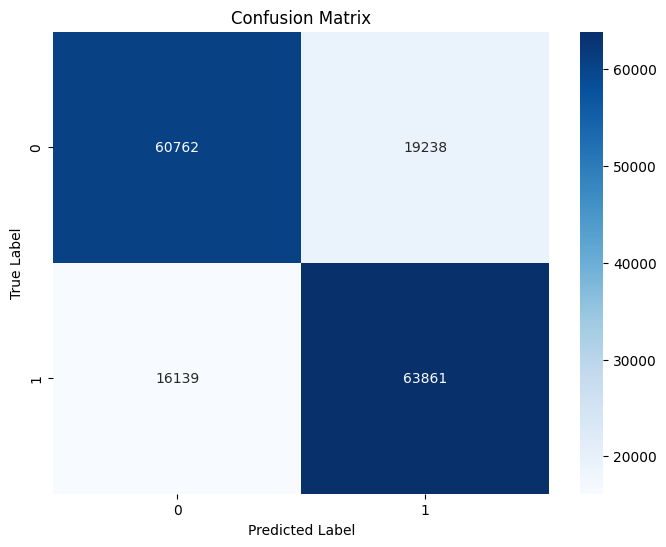

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of testing data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

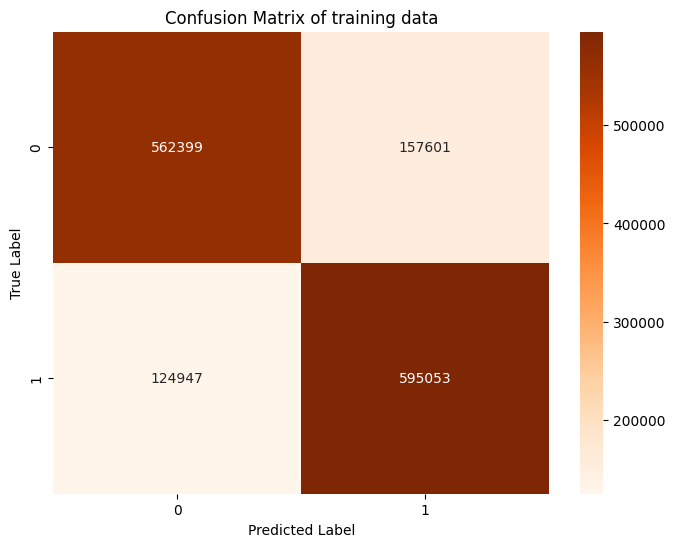

In [82]:
plt.figure(figsize=(8, 6))
sns.heatmap(com, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix of training data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

SAVING THE TRAINED FILE

In [52]:
import pickle
filename='trained-model.sav'
pickle.dump(model, open(filename, 'wb'))

USING THE SAVED MODEL FOR NEW PREDICTIONS

In [67]:
#LOADING THE SAVED MODEL
loaded_model=pickle.load(open('trained-model.sav','rb'))

In [68]:
X_new=X_test[1]
print(X_new)


  (0, 23344)	0.3365984529499188
  (0, 51593)	0.2473013225678171
  (0, 53782)	0.3372365781457033
  (0, 114644)	0.20813228546942747
  (0, 127433)	0.2673950821601698
  (0, 161559)	0.12878616634004003
  (0, 169850)	0.18198458024036512
  (0, 182386)	0.30464244800101703
  (0, 234424)	0.3614926380681113
  (0, 328292)	0.4032554322189012
  (0, 388260)	0.2527978056479474
  (0, 402402)	0.2544262864362059
  (0, 469696)	0.18042512989832027


In [69]:
print(Y_test[1])

0


In [55]:
prediction=loaded_model.predict(X_new)
print(prediction)

[0]


In [70]:
if prediction[0]==0:
  print('Negative Tweet')
else:
  print('Positive Tweet')

Negative Tweet


In [71]:
X_new=X_test[8888]
print(X_new)

  (0, 134590)	0.3210309395558218
  (0, 135487)	0.2962540028364162
  (0, 142576)	0.27546652098772106
  (0, 168543)	0.27332103822281906
  (0, 312533)	0.5165006865276537
  (0, 365477)	0.5559884302880637
  (0, 425348)	0.2875594090502101


In [72]:
print(Y_test[8888])

1


In [73]:
prediction=loaded_model.predict(X_new)
print(prediction)

[1]


In [74]:
if prediction[0]==0:
  print('Negative Tweet')
else:
  print('Positive Tweet')

Positive Tweet
